In [1]:
import os

import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from datasets import load_dataset

from main_model import Colorizer
from dataloader_resnet import NoisyImageNetDataset

In [2]:
DEVICE             = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
CACHE_DIR          = "/scratch/public_scratch/gp/DIP/ImageNet-1k/"
CHECKPOINT_DIR     = "/scratch/public_scratch/gp/DIP/checkpoints/"

In [3]:
val_dataset = load_dataset(
    'imagenet-1k', split='validation', streaming=True,
    cache_dir=CACHE_DIR, trust_remote_code=True
)
noisy_val_dataset = NoisyImageNetDataset(val_dataset)

In [4]:
sample = next(iter(noisy_val_dataset))

denoised_gray = sample['denoised_gray'].unsqueeze(0).to(DEVICE)
original_rgb  = sample['original_rgb'].unsqueeze(0).to(DEVICE)

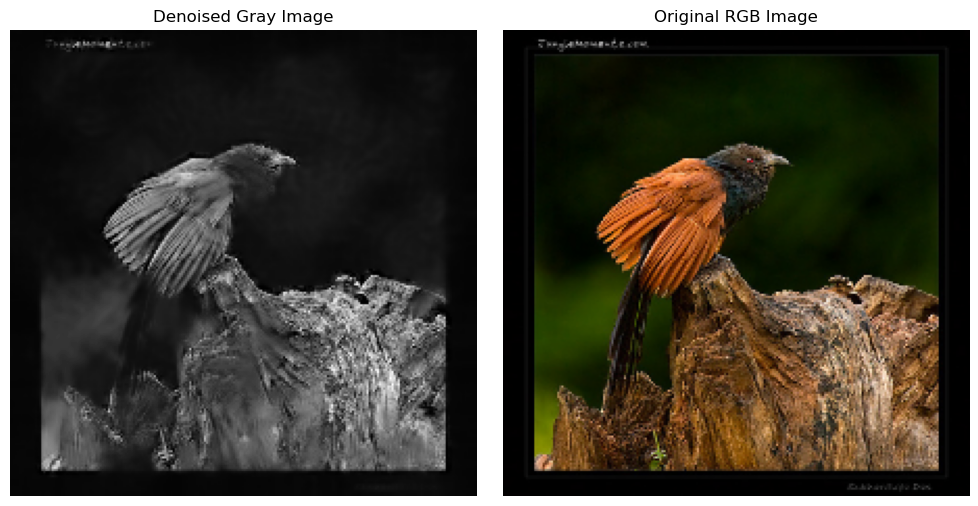

In [5]:
_, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(denoised_gray.squeeze().cpu().numpy(), cmap='gray')
axs[0].set_title("Denoised Gray Image")
axs[0].axis('off')

axs[1].imshow(original_rgb.squeeze(0).permute(1, 2, 0).cpu().numpy())
axs[1].set_title("Original RGB Image")
axs[1].axis('off')

plt.tight_layout()
plt.show()

In [6]:
model = Colorizer().to(DEVICE)
model.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR, "resnet_colorizer_with_JBF_0.0001_0.01_1000_epoch_3_batch_1000.pth"))['model_state_dict'])
model.eval()

Colorizer(
  (feature_extractor): ResNetFeatureExtractor(
    (init_layer): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchN

In [7]:
results_folder = '../results/JBF_epoch_3_batch_1k/'
os.makedirs(results_folder, exist_ok=True)

for i, sample in enumerate(tqdm(noisy_val_dataset)):
    denoised_gray = sample['denoised_gray'].unsqueeze(0).to(DEVICE)
    original_rgb  = sample['original_rgb'].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        uv_channels = model(denoised_gray)

    pred_rgb = model.uv_to_rgb(denoised_gray, uv_channels)

    denoised_gray_plt = denoised_gray.squeeze().cpu().numpy()
    original_rgb_plt  = original_rgb.squeeze().permute(1, 2, 0).cpu().numpy()
    pred_rgb_plt      = pred_rgb.squeeze().permute(1, 2, 0).cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(denoised_gray_plt, cmap='gray')
    axs[0].set_title("Denoised Gray")
    axs[0].axis('off')

    axs[1].imshow(original_rgb_plt)
    axs[1].set_title("Original RGB")
    axs[1].axis('off')

    axs[2].imshow(pred_rgb_plt)
    axs[2].set_title("Predicted RGB")
    axs[2].axis('off')

    plt.savefig(os.path.join(results_folder, f"{i}.png"), bbox_inches='tight')
    plt.close()

    if i == 100:
        break

0it [00:00, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2it [00:03,  1.37s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
4it [00:03,  1.57it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
5it [00:04,  1.95it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
6it [00:04,  2.31it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
7it [00:04,  2.29it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
9it [00:05,  2.84it/s]WARNING:matplotlib.image:Clipping input 